In [1]:
%matplotlib notebook
from matplotlib import pyplot
import tensorflow as tf
from time import time
import numpy
import pandas
import pickle
import h5py
import os
import multiprocessing
from functools import partial
from scipy import signal
from Brett import pipeline, conv_model, data_util, prepare_data, db

### Extraction Progress

In [2]:
files = os.listdir('/scr1/mimic/waveforms')
print(sum('y128.pkl' in i for i in files), 'of', sum('y.pkl' in i for i in files))

7964 of 21316


In [5]:
k = (3997242, 25)
rec = db.read_record(k, root='/scr1/mimic/waveforms/', compute_physical=False)
INPUT_SIGS = ['II', 'V', 'PLETH', 'RESP']
OUTPUT_SIGS = ['ABP']
S = INPUT_SIGS + OUTPUT_SIGS
I = [rec.sig_name.index(i) for i in S if i in rec.sig_name]
X = rec.d_signal[:, I]
X

array([[  0, 483, 842, 523],
       [347, 480, 841, 511],
       [363, 477, 839, 496],
       ...,
       [365, 494, 284,   0],
       [370, 521, 284,   0],
       [373, 545, 283,   0]], dtype=int16)

### Load

In [3]:
%%time

root = '/scr1/mimic/waveforms/'
paths = [root + i for i in os.listdir(root) if '.y128.pkl' in i]
pressures = {}
for path in paths:
    with open(path, 'rb') as f:
        y = pickle.load(f)
        for i in y:
            if 'y' not in i and y[i] is not None and len(y[i]) > 0:
                rec_id = tuple([int(j) for j in i.split('_')])
                pressures[rec_id] = y[i]
                
print(len(pressures), len(paths))

102424 5777
CPU times: user 1.75 s, sys: 2.6 s, total: 4.35 s
Wall time: 4.35 s


<IPython.core.display.Javascript object>


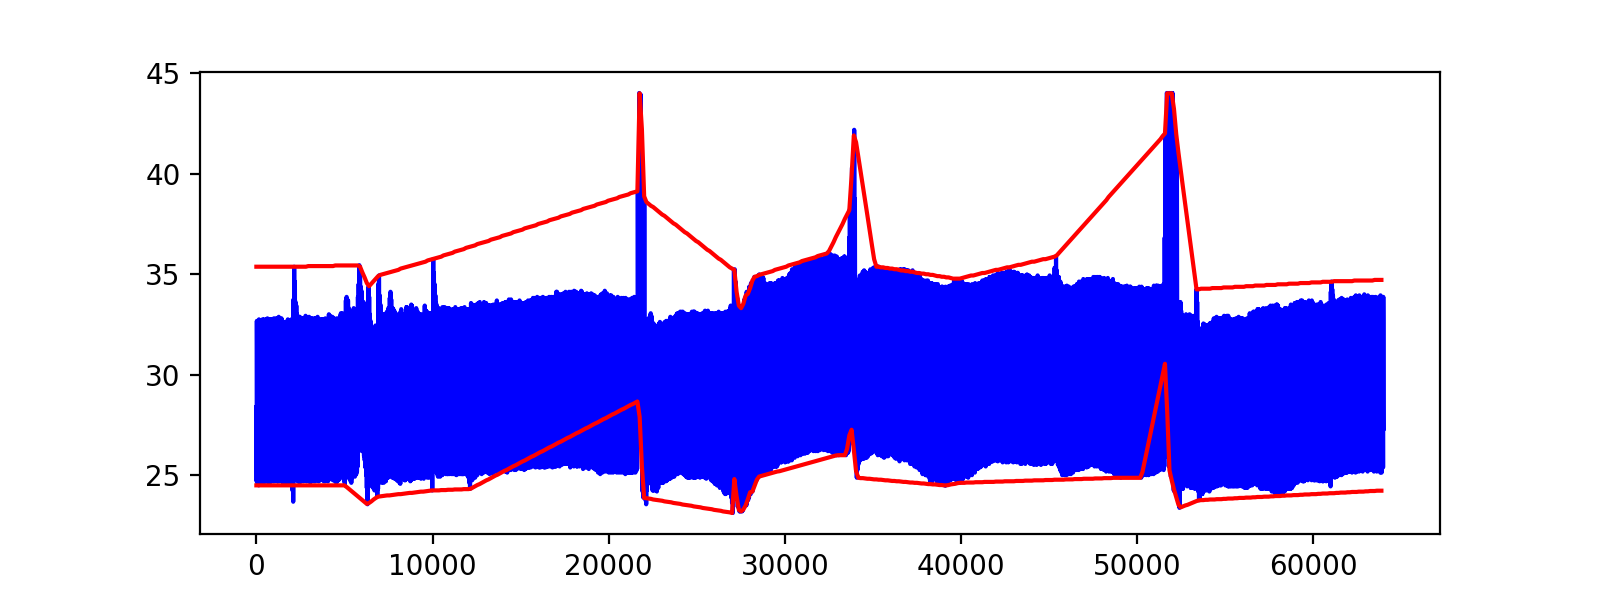

In [163]:
i = 1
di = 500
# k = list(k for k in pressures if len(pressures[k]) > i + di)[300]
k = (3997242, 25)
rec = db.read_record(k, root='/scr1/mimic/waveforms/', y_only=True)
pyplot.figure(figsize=[8,3])
pyplot.plot(rec.p_signal[i*128:(i+di)*128, rec.sig_name.index('ABP')], 'b')
pyplot.plot(range(0, di*128, 128), pressures[k][i-1:i+di-1], 'r')

### Smooth

In [42]:
def smooth_pressure(y, w=300):
    w = min(w, y.shape[0])
    w -= w % 2 == 0
    return signal.savgol_filter(y, w, 1, axis=0)

In [47]:
%%time

w = 300
pressures_smooth = {}
for i in pressures:
    if len(pressures[i]) > w:
        pressures_smooth[i] = smooth_pressure(pressures[i], w)

CPU times: user 4min 34s, sys: 10.7 s, total: 4min 45s
Wall time: 4min 42s


<IPython.core.display.Javascript object>


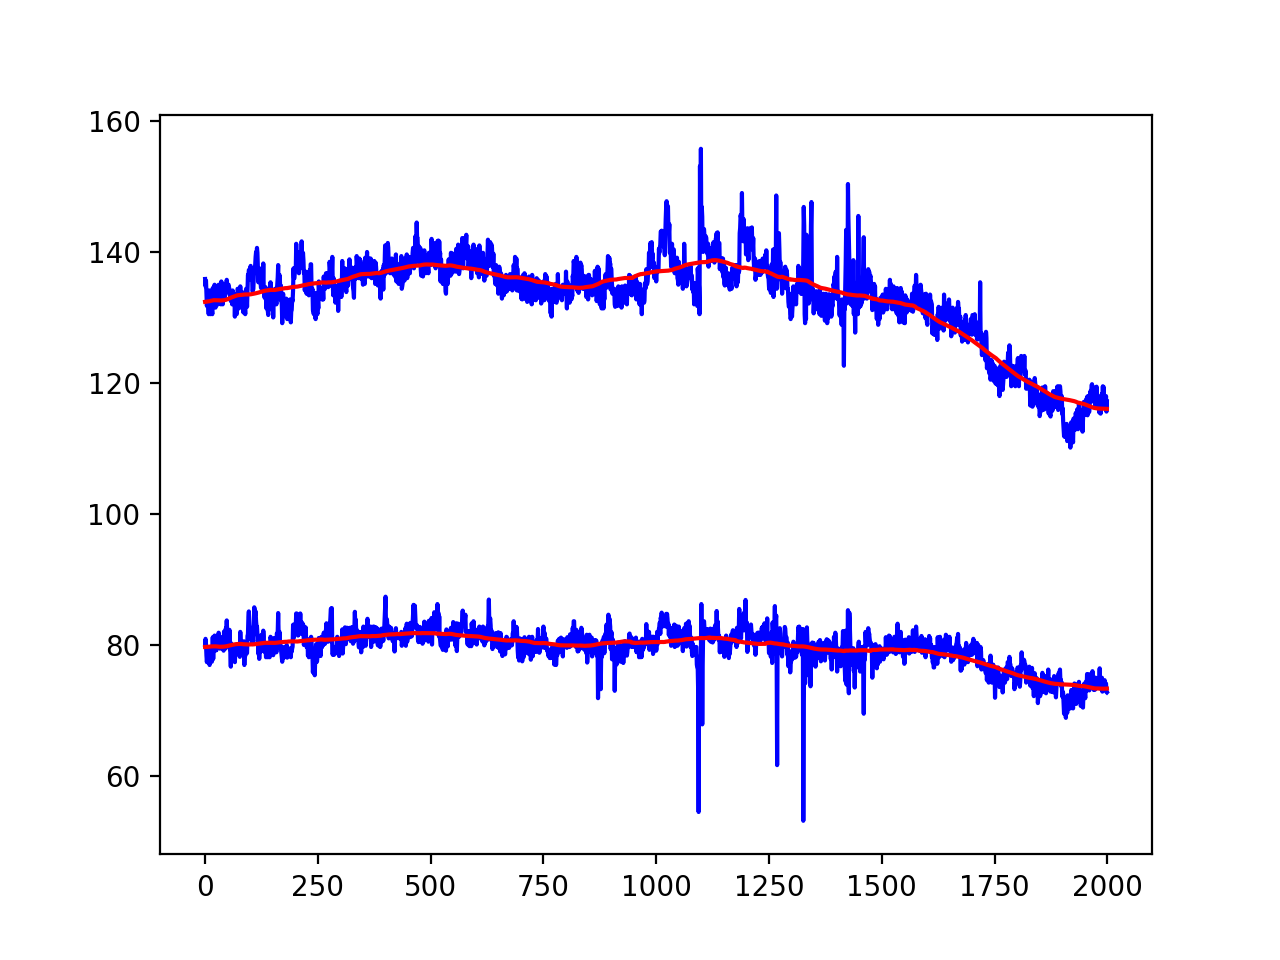

In [142]:
k = next(iter(pressures))
i = 3000
di = 2000
pyplot.figure()
pyplot.plot(pressures[k][i:i+di], 'b')
pyplot.plot(pressures_smooth[k][i:i+di], 'r')

### Chunk

In [4]:
%%time

m = prepare_data.CHUNK_SIZE // 128
P = {}
for k, p in pressures.items():
    if p.shape[0] > m:
        P[k] = p[:-(p.shape[0]%m)].reshape([-1, m, 2])

CPU times: user 152 ms, sys: 8 ms, total: 160 ms
Wall time: 159 ms


### Write HDF5

In [15]:
%%time

h5file = '/scr-ssd/mimic/pressures_test.hdf5'

with h5py.File(h5file, 'w') as f:
    for i in P:
        f.create_dataset(db.rec_id_to_string(i), data=P[i])

print(round(os.path.getsize(h5file) * 1e-9, 2), 'GB')

3.12 GB
CPU times: user 10.3 s, sys: 3.13 s, total: 13.4 s
Wall time: 15.1 s


### Write Pickle

In [16]:
%%time

pklfile = '/scr-ssd/mimic/pressures_test.pkl'

with open(pklfile, 'wb') as f:
    pickle.dump(P, f)

print(round(os.path.getsize(pklfile) * 1e-9, 2), 'GB')

3.1 GB
CPU times: user 1.6 s, sys: 3.79 s, total: 5.38 s
Wall time: 6.93 s


### Read HDF5

In [52]:
%%time

with h5py.File(h5file, 'r') as f:
    P = {db.rec_id_to_tuple(i): f[i].value for i in f.keys()}

CPU times: user 14.1 s, sys: 1.7 s, total: 15.8 s
Wall time: 15.8 s


### Read Pickle

In [19]:
%%time

P = pickle.load(open(pklfile, 'rb'))

CPU times: user 1.66 s, sys: 1.13 s, total: 2.8 s
Wall time: 2.79 s
